In [0]:
import warnings
warnings.filterwarnings(action='once')

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.datasets import cifar10

#loading data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_train, img_channels, img_rows, img_cols = x_train.shape
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))


# Classes
class_names = ['airplane', 'automobile', 'bird', 'cat',  
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# multi line f-string : https://stackoverflow.com/questions/45965007/multiline-f-string-in-python
print(f"""
Train images : {num_train}
Test images : {num_test}
Total classes : {num_classes}
Input image shape : {x_train.shape[1:]}
""")

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5747: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  ret


Train images : 50000
Test images : 10000
Total classes : 10
Input image shape : (32, 32, 3)



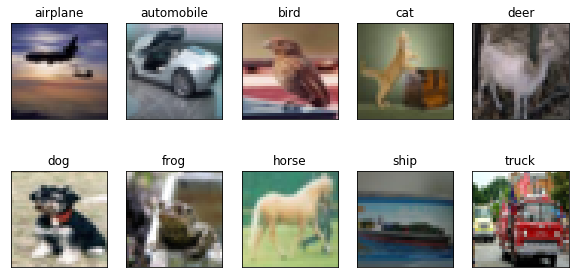

In [4]:
# checking some random images
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0] # selecting image_idx of single class
  features = x_train[idx,::]
  img_num = np.random.randint(features.shape[0])
  im = features[img_num]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

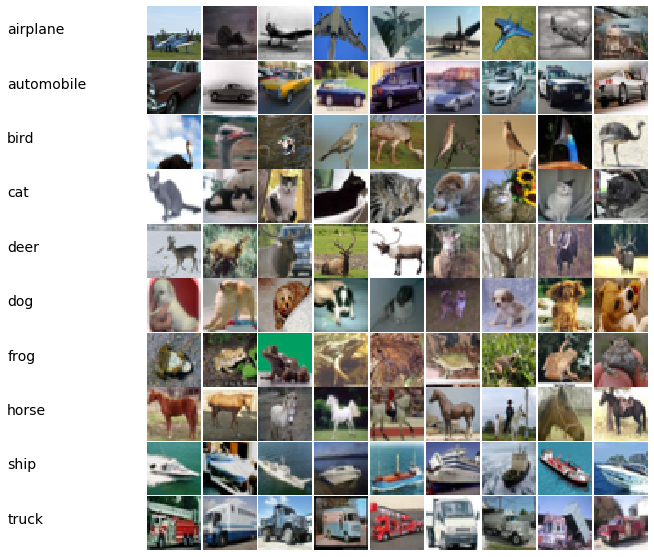

In [5]:
# display n random images for each class
n = 10
r, c = 10, n
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(y_train[:]==i)[0], c, replace=False)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, c):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(x_train[idx[j-1]], interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [0]:
version = 2

batch_size = 128  
epochs = 50
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy


depth = 20

In [0]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Normalizing data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def plot_model_history(model_history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # summarize history for accuracy
  ax[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])#, label='Training Acc')
  ax[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])#, label='Validation Acc')
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  ax[0].legend(['Train', 'Validation'], loc='best')

  # summarize history for loss
  ax[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  ax[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  ax[1].legend(['Train', 'Validation'], loc='best')

  plt.show()

In [0]:
def lr_schedule(epoch):
  lr = round(0.003 * pow(0.5, epoch//8), 10) #  halving lr every 8 epochs
  print ('Learning rate is : ', lr)
  return lr
# print([ lr_schedule(e) for e in range(50)])

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """
    2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [12]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v2(input_shape=x_train.shape[1:], depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)













Learning rate is :  0.003


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [14]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model_info = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=50, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate is :  0.003
391/391 [==============================] - 42s 108ms/step - loss: 1.7156 - acc: 0.4934 - val_loss: 1.5932 - val_acc: 0.5207

Epoch 00001: val_acc improved from -inf to 0.52070, saving model to /content/saved_models/cifar10_ResNet20v2_model.001.h5
Epoch 2/50
Learning rate is :  0.003
391/391 [==============================] - 36s 91ms/step - loss: 1.3012 - acc: 0.6225 - val_loss: 1.3332 - val_acc: 0.6151

Epoch 00002: val_acc improved from 0.52070 to 0.61510, saving model to /content/saved_models/cifar10_ResNet20v2_model.002.h5
Epoch 3/50
Learning rate is :  0.003
391/391 [==============================] - 36s 91ms/step - loss: 1.1413 - acc: 0.6758 - val_loss: 1.3342 - val_acc: 0.6395

Epoch 00003: val_acc improved from 0.61510 to 0.63950, saving model to /content/saved_models/cifar10_ResNet20v2_model.003.h5
Epoch 4/50
Le

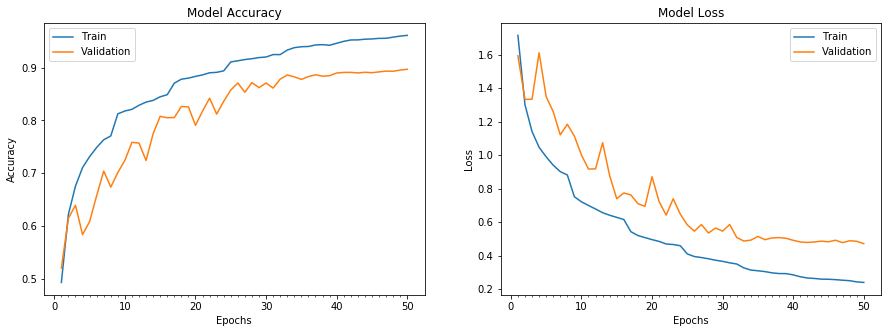

In [15]:
# plot model history
plot_model_history(model_info)

Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.003
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.0015
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.00075
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.000375
Learning rate is :  0.0001875
Learning rate is :  0.0001875
Learning rate is :  0.0001875
Learning rate is :  0.0001875


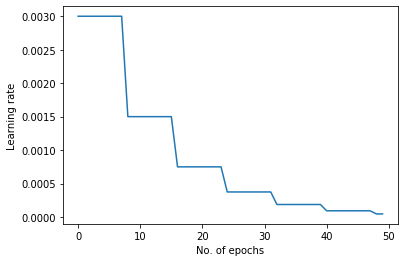

In [16]:
plt.plot([ lr_schedule(e) for e in range(50)])
plt.xlabel('No. of epochs')
plt.ylabel('Learning rate')
plt.show()

### GradCAM

In [17]:
from skimage import io
import cv2

from keras.preprocessing import image
from keras.applications.resnet import resnet, preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [0]:
url = 'https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg'
url_class = 'dog'

In [0]:
def get_gradcam(url, url_class):
  # read and resize image
  img = io.imread(url)
  orig_shape = (img.shape[1], img.shape[0])
  print('Input url :', url)
  print('=='*36)
  print('Label :',url_class)
  print('Original image')
  cv2_imshow(img)
  print('--'*81)


  img = cv2.resize(img, dsize=(32,32), interpolation=cv2.INTER_CUBIC) # resize img to model input shape 
  # Normalizing and changing shape for model prediction
  pred_img = image.img_to_array(img/255)
  pred_img = np.expand_dims(pred_img, axis=0)

  # If subtract pixel mean is enabled
  if subtract_pixel_mean:
    pred_img -= x_train_mean

  y_pred = model.predict(pred_img)
  class_idx = np.argmax(y_pred[0])
  print('Predicted Label :',class_names[class_idx])

  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer('conv2d_22')
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  # find the average for each channel of gradients
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # get iterator to parse input and compute the tensor
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # actually compute for the given input
  pooled_grads_value, conv_layer_output_value = iterate([pred_img])

  # multiple the pooled gradients with each channel output
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # add all channels and divide by 64, i.e. the mean as heatmap
  heatmap = np.mean(conv_layer_output_value, axis = -1)

  # apply RELU, i.e. reject all negative values and normalize by dividing by maximum
  # so that all values are between -0 and 1
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  # resize heatmap to actual image resolution i.e. 32x32 and scale from 0 to 255 with colormap
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # superimpore input and output
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

  # scale superimposed image for clarity 4 times
  superimposed_img = cv2.resize(superimposed_img, orig_shape)
  print('GradCAM Heat Maps based on Network activations for class')
  cv2_imshow(superimposed_img)
  print('**'*18)
  print('**'*18)

Input url : https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg
Label : dog
Original image


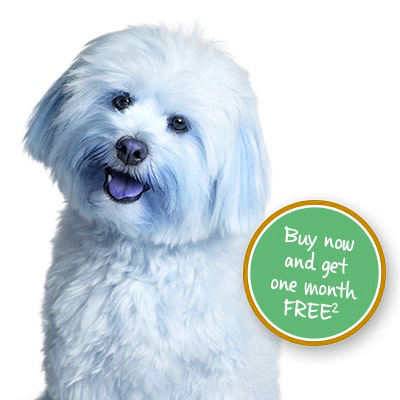

------------------------------------------------------------------------------------------------------------------------------------------------------------------
Predicted Label : dog
GradCAM Heat Maps based on Network activations for class


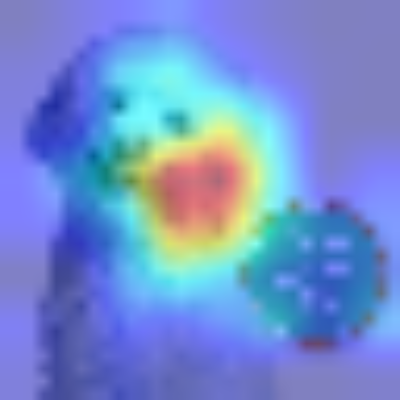

************************************
************************************


In [24]:
get_gradcam(url, url_class)

In [0]:
airplanes = ['https://images.unsplash.com/photo-1543903905-cee4ab46985c', 'https://images.unsplash.com/photo-1559711469-31b420b24c10', 'https://images.unsplash.com/photo-1559023234-1e773470544f', 'https://images.unsplash.com/photo-1562368370-cff10978a647', 'https://images.unsplash.com/photo-1531642765602-5cae8bbbf285']
cars = ['https://images.unsplash.com/photo-1523676060187-f55189a71f5e', 'https://images.unsplash.com/photo-1532974297617-c0f05fe48bff', 'https://images.unsplash.com/photo-1485291571150-772bcfc10da5', 'https://images.unsplash.com/photo-1489824904134-891ab64532f1', 'https://images.unsplash.com/photo-1503376780353-7e6692767b70', 'https://images.unsplash.com/photo-1529369623266-f5264b696110']
birds = ['https://images.unsplash.com/photo-1448227922836-6d05b3f8b663', 'https://images.unsplash.com/photo-1433321768402-897b0324c   ', 'https://images.unsplash.com/photo-1507477338202-487281e6c27e', 'https://images.unsplash.com/photo-1471602671180-19fb2b491359', 'https://images.unsplash.com/photo-1506220926022-cc5c12acdb35', 'https://images.unsplash.com/photo-1511692277506-3be3a7ab1686']


In [0]:
for url in airplanes:
  get_gradcam(url, 'airplane')

Input url : https://images.unsplash.com/photo-1543903905-cee4ab46985c
Label : airplane
Original image


In [0]:
for url in cars:
  get_gradcam(url, 'automobile')

In [0]:
for url in birds:
  get_gradcam(url, 'bird')

In [0]:
cat = ['https://images.unsplash.com/photo-1548681528-6a5c45b66b42, 'https://images.unsplash.com/photo-1543852786-1cf6624b9987, 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba, 'https://images.unsplash.com/photo-1519052537078-e6302a4968d4, 'https://images.unsplash.com/photo-1501820488136-72669149e0d4, 'https://images.unsplash.com/photo-1526336024174-e58f5cdd8e13, 'https://images.unsplash.com/photo-1513360371669-4adf3dd7dff8']
deer = ['https://images.unsplash.com/photo-1484406566174-9da000fda645, 'https://images.unsplash.com/photo-1537694513497-5f0b0ec361c7, 'https://images.unsplash.com/photo-1542890886-40c9094e352a, 'https://images.unsplash.com/photo-1565440707934-c9bacbad2146']
dog = ['https://images.unsplash.com/photo-1534361960057-19889db9621e', 'https://images.unsplash.com/photo-1548199973-03cce0bbc87b']

In [0]:
for url in cat:
  get_gradcam(url, 'cat')

In [0]:
for url in deer:
  get_gradcam(url, 'deer')